Notebook generating pickle files to avoid re-running the Monte Carlo Simulation


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import statsmodels.api as sm
from scipy.stats import t
from multiprocessing import Pool
import os
from statsmodels.tsa.arima.model import ARIMA
import pickle
from statsmodels.tsa.stattools import adfuller

Data cleaning and Pre-processing

In [92]:
sheet_names = ["Financials", "OilandGas", "Auto", "Hotels"]


In [93]:
#Price are adjusted close prices.
list_datas = []
for sheet in sheet_names :
    data = pd.read_excel("data.xlsx", sheet_name = sheet)
    data.drop(0, inplace = True)
    data.rename(columns= {"Name" : "date"}, inplace=True)
    data["date"] =pd.to_datetime(data["date"])
    data.set_index("date",inplace = True)
    list_datas.append(data)

data_prices = pd.concat(list_datas, axis = 1)    

data_prices = data_prices.astype(float)


In [94]:
def remove_parentheses(column_name):
    return column_name.split(' (')[0]

# Apply the function to each column name
data_prices.columns = [remove_parentheses(col) for col in data_prices.columns]
data_prices.rename(columns = {"VISA 'A'" : "VISA"}, inplace = True)

In [95]:
with open('./pickles/data_prices.pkl', 'wb') as file:
   pickle.dump(data_prices, file)

Descriptive Statistics 

In [58]:
def returns_computation(dataframe) :

    #Simple returns 
    daily_returns_df = dataframe.pct_change().bfill()

    weekly_returns_df = (1+daily_returns_df).resample("W").prod() - 1
    
    #log returns formula 
    daily_log_returns_df = np.log(dataframe/dataframe.shift(1))

    weekly_log_returns_df = (daily_log_returns_df).resample("W").sum()

    # Return the computed dataframes
    return daily_returns_df, weekly_returns_df, daily_log_returns_df, weekly_log_returns_df

    


In [59]:
def descriptive_daily_stats(dataframe, daily_returns_dataframe, daily_log_returns_dataframe):
    # Create an empty list to store each asset's stats
    results_list = []
    # Compute number of trading days for the first year of the dataframe for this asset
   
    
    # Iterate over each column/asset in the returns dataframes
    for asset in dataframe.columns:
        year_mask = dataframe.index.year == dataframe.index.year[0]
        nbr_trading_days = len(dataframe.loc[year_mask, asset])
    

        # Collect stats for the asset
        stats = {
            'Asset': asset,
            'Annualized Mean': daily_returns_dataframe[asset].mean() * nbr_trading_days,
            'Annualized Mean Log': daily_log_returns_dataframe[asset].mean() * nbr_trading_days,
            'Annualized Variance': daily_returns_dataframe[asset].var() * nbr_trading_days,
            'Annualized Variance Log': daily_log_returns_dataframe[asset].var() * nbr_trading_days,
            'Skewness': daily_returns_dataframe[asset].skew(),
            'Skewness Log': daily_log_returns_dataframe[asset].skew(),
            'Kurtosis': daily_returns_dataframe[asset].kurt(),
            'Kurtosis Log': daily_log_returns_dataframe[asset].kurt(),
            'Min Daily Returns': daily_returns_dataframe[asset].min(),
            'Max Daily Returns': daily_returns_dataframe[asset].max(),
            'Min Daily Log Returns': daily_log_returns_dataframe[asset].min(),
            'Max Daily Log Returns': daily_log_returns_dataframe[asset].max()
        }
        
        # Append the dictionary of stats to the results list
        results_list.append(stats)

    # Convert list of dictionaries to a DataFrame
    results_df = pd.DataFrame(results_list)
    # Set 'Asset' as index if desired
    results_df.set_index('Asset', inplace=True)

    return results_df



In [60]:
daily_returns_dataframe, weekly_returns_dataframe, daily_log_returns_dataframe, weekly_log_returns_dataframe= returns_computation(data_prices)
summary_stats_dataframe = descriptive_daily_stats(data_prices, daily_returns_dataframe, daily_log_returns_dataframe)

### Stationarity :
* Dickey-Fuller test
* For each series of Price we run the following regression : $p_t = \mu + \phi* p_{t-1} + \epsilon_{t} $  where $p_t = log(P_t)$

* $H_{0}$ :Unit root exists i.e not stationary $\phi =1$ -> Random walk process
* $H_{1}$: Series is stationary $\phi =1<1$ 

* Can be re-written DF as : $\Delta p_{t} =  \mu + \delta p_{t-1} + \epsilon_{t}\phi$ where $\delta = 1-\phi$
* $H_{0}$ : Unit root exist if $1-\phi = 0$

* But let's see why do we compute the t-stat as = $t*(1- (\phi^{i}))$
* $\phi$ : Estimated coeffecient of the lagged variable in AR(1) model
* $\phi -1$ : This substraction tranforms the test into a hypothesis wether $\phi$ is different than one, if $\phi$ is exactly 1 the series is a random walk
* t: the t value of $\phi$ coeffecient measures how many standard errors the estimated coeffecient is away from 0 . the t-value is computed to test the null that a coefficient equals 0 not 1 .
* In the context of DF test, we want to test wether $\phi$ differs significantly form 1 not 0. Therefore the adjustment ($\phi -1 $) must be madw
* By doing this multiplication : we transform the t-stat into a form that tests $H_0 : \phi =1$ i.e how many standard errors the estimated coeffecient is far from 1
* In the Monte Carlo simulations, by collecting the distribution of these modified t-statistics, we can then empirically derive the critical values for the test, which tell us how extreme the t-statistic must be for us to reject the null hypothesis at a given significance level.
* We simulated the t-stats of unit root process. Logically, if we fall outside the critical values. we reject $H_0$ namely that our series does not contain a unit root and hence is stationary
* We are computing manuallay the critical values for Dfuller test

In [61]:
#Use pickle files or de-comment and run the code but takes time.
''' 

# Define the simulation function
def simulation_run(iteration):
    error_term = np.random.normal(loc=0, scale=1, size=len(data_prices))
    prices = np.cumsum(error_term)  # Assuming p_0 = 0
    model = ARIMA(prices, order=(1, 0, 0), trend='c')
    res = model.fit()
    t_val = res.tvalues[1]   # Getting the t_stat of the lagged value
    coeff = res.params[1]
    t_statistic = t_val * (coeff - 1)
    return t_statistic

# Function to execute parallel simulations
def execute_parallel_simulations(num_simulations, pool_size):
    # Pool size is the number of processes to run in parallel
    pool = Pool(pool_size)
    t_stat_array = pool.map(simulation_run, range(num_simulations))
    pool.close()
    pool.join()
    return t_stat_array

# Set the number of simulations and the pool size
N = 10000  # Number of simulations
pool_size = os.cpu_count()  # Number of CPU cores available


if __name__ == "__main__":
     t_stat_array = execute_parallel_simulations(N, pool_size)

# # Calculate critical values
critical_vals = {
    "10%-Quantile": np.quantile(t_stat_array, 0.10),
    "5%-Quantile": np.quantile(t_stat_array, 0.05),
    "1%-Quantile": np.quantile(t_stat_array, 0.01)
}

'''


' \n\n# Define the simulation function\ndef simulation_run(iteration):\n    error_term = np.random.normal(loc=0, scale=1, size=len(data_prices))\n    prices = np.cumsum(error_term)  # Assuming p_0 = 0\n    model = ARIMA(prices, order=(1, 0, 0), trend=\'c\')\n    res = model.fit()\n    t_val = res.tvalues[1]   # Getting the t_stat of the lagged value\n    coeff = res.params[1]\n    t_statistic = t_val * (coeff - 1)\n    return t_statistic\n\n# Function to execute parallel simulations\ndef execute_parallel_simulations(num_simulations, pool_size):\n    # Pool size is the number of processes to run in parallel\n    pool = Pool(pool_size)\n    t_stat_array = pool.map(simulation_run, range(num_simulations))\n    pool.close()\n    pool.join()\n    return t_stat_array\n\n# Set the number of simulations and the pool size\nN = 10000  # Number of simulations\npool_size = os.cpu_count()  # Number of CPU cores available\n\n\nif __name__ == "__main__":\n     t_stat_array = execute_parallel_simulatio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


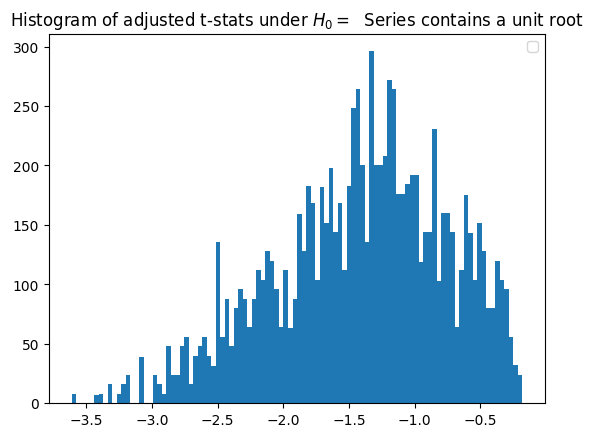

In [62]:
# Load t_stat_array from a pickle file
with open('./pickles/t_stat_array.pkl', 'rb') as file:
    t_stat_array = pickle.load(file)

# Load critical_vals from a pickle file
with open('./pickles/critical_vals.pkl', 'rb') as file:
    critical_vals = pickle.load(file)


plt.hist(t_stat_array, bins = 100)
plt.title("Histogram of adjusted t-stats under $H_{0} =$  Series contains a unit root")
plt.legend()
# Load t_stat_array from a pickle file
plt.show()

Re-do the simulation but for T =500

In [63]:
#Use pickle files or de-comment and run the code but takes time.
''''
def simulation_run(iteration):
    T = 500
    error_term = np.random.normal(loc=0, scale=1, size=T)  # Adjust T as needed
    prices = np.cumsum(error_term)  # Assuming p_0 = 0
    model = ARIMA(prices, order=(1, 0, 0), trend='c')
    res = model.fit()
    t_val = res.tvalues[1]   # Getting the t_stat of the lagged value
    coeff = res.params[1]
    t_statistic = t_val * (coeff - 1)
    return t_statistic

# Function to execute parallel simulations
def execute_parallel_simulations(num_simulations, pool_size):
    # Pool size is the number of processes to run in parallel
    pool = Pool(pool_size)
    t_stat_array_500 = pool.map(simulation_run, range(num_simulations))
    pool.close()
    pool.join()
    return t_stat_array_500

# Set the number of simulations and the pool size
N = 10000  # Number of simulations
pool_size = os.cpu_count()  # Number of CPU cores available

# Run the Monte Carlo simulations in a local environment with the following block
if __name__ == "__main__":
    t_stat_array_500 = execute_parallel_simulations(N, pool_size)

    # Calculate critical values
    critical_vals_500 = {
        "10%-Quantile": np.quantile(t_stat_array_500, 0.10),
        "5%-Quantile": np.quantile(t_stat_array_500, 0.05),
        "1%-Quantile": np.quantile(t_stat_array_500, 0.01)
    }

    '''


'\'\ndef simulation_run(iteration):\n    T = 500\n    error_term = np.random.normal(loc=0, scale=1, size=T)  # Adjust T as needed\n    prices = np.cumsum(error_term)  # Assuming p_0 = 0\n    model = ARIMA(prices, order=(1, 0, 0), trend=\'c\')\n    res = model.fit()\n    t_val = res.tvalues[1]   # Getting the t_stat of the lagged value\n    coeff = res.params[1]\n    t_statistic = t_val * (coeff - 1)\n    return t_statistic\n\n# Function to execute parallel simulations\ndef execute_parallel_simulations(num_simulations, pool_size):\n    # Pool size is the number of processes to run in parallel\n    pool = Pool(pool_size)\n    t_stat_array_500 = pool.map(simulation_run, range(num_simulations))\n    pool.close()\n    pool.join()\n    return t_stat_array_500\n\n# Set the number of simulations and the pool size\nN = 10000  # Number of simulations\npool_size = os.cpu_count()  # Number of CPU cores available\n\n# Run the Monte Carlo simulations in a local environment with the following block\n

In [64]:
# Load t_stat_array from a pickle file
with open('./pickles/t_stat_array.pkl', 'rb') as file:
    t_stat_array_500 = pickle.load(file)

# Load critical_vals from a pickle file
with open('./pickles/critical_vals.pkl', 'rb') as file:
    critical_vals_500 = pickle.load(file)

Co-integration :
* To test for cointegration between for the pair (A-B), we proceed as follows:
* First, we estimate their relationship by running a regression between their contemporaneous log prices : $p^{A}_{t} = \alpha + \beta p^{B}_{t}+ z_t $ where $z_t$ is the error term of the regression, it represents the part of Asset A's price that is not explained by Asset B's price. If A and B are co-integrated, $z_t$ should capture the equilibrium error- the deviation from the long-term equilibrium between the two assets
* Secondly Then, we use the Dickey-Fuller test for testing the null of unit root in $z_t$ . So we estimate the regression : $\Delta z_{t} = \mu + \phi z_{t}  + \epsilon_{t}$. If A and B are co-integrated even if A and B are non stationary (e.g have both unit roots),their linear relationship which is captured by the residuals should be stationary. So we use DF test to asses the stationarity of $z_t$. If you can reject the null hypothesis (typically if $\phi$ is significantly negative), it indicates that the residuals $z_t$​ do not have a unit root and are stationary. This is evidence of cointegration between A and B, suggesting that any deviations from the equilibrium relationship are temporary and that the prices will move back towards equilibrium.




Now as before we will compute our own critical values :
* Simulate two time seires of independent random walks : $p_{t}^{A} = p_{t-1}^{A} + \epsilon_{t}^{A}$ and $p_{t}^{B} = p_{t-1}^{B} + \epsilon_{t}^{B}$. Error terms are N(0,1)

* Estime the linear relationship : $p^{A}_{t} = \alpha + \beta p^{B}_{t}+ z_t $

* Under $H_0$ : No-cointegration, the residuals $z_t$ shouldn't be stationary

* We perform dfuller test on $z_t$ : we asses the stationarity of $z_t$ 
* Estimate AR(1) model for residuals. under alternative hypothesis : $\Delta z_t = \mu + \phi  z_{t-1} + \epsilon_{t}$

* When you simulate two independent random walks, you're effectively creating two time series where each step in each series is determined by the previous step plus a random error, and the error terms are drawn from a normal distribution N(0,1)N(0,1). Crucially, since these two series are generated independently of each other, there is no inherent or underlying link between their movements—any observed relationship in a regression analysis would be purely coincidental (or spurious). Hence your $H_0$ : No co-integration

In [66]:
''' 
def simulation_run(iteration):
    T = len(data_prices)
    error_term_1, error_term_2 = np.random.normal(loc=0, scale=1, size=T), np.random.normal(loc=0, scale=1, size=T)  
    p_t_1, p_t_2 = np.cumsum(error_term_1), np.cumsum(error_term_2)  
    
    #Linear relationship estimation
    model_lin_reg = sm.OLS(p_t_1, sm.add_constant(p_t_2))
    res = model_lin_reg.fit()
    residuals = pd.Series(res.resid)[1:]
    df_test = adfuller(residuals)    
    
    residuals_shifted = residuals.shift(1)[1:]

    delta_residuals = residuals - residuals_shifted
    
    
    
    model = ARIMA(delta_residuals, order=(1, 0, 0), trend='c')
    res = model.fit()
    t_stat = res.tvalues[1]   # Getting the t_stat of the lagged value
    
    return t_stat

# Function to execute parallel simulations
def execute_parallel_simulations(num_simulations, pool_size):
    # Pool size is the number of processes to run in parallel
    pool = Pool(pool_size)
    t_stat_array_cointegration = pool.map(simulation_run, range(num_simulations))
    pool.close()
    pool.join()
    return t_stat_array_cointegration

# Set the number of simulations and the pool size
N = 1000  # Number of simulations
pool_size = os.cpu_count()  # Number of CPU cores available

# Run the Monte Carlo simulations in a local environment with the following block
if __name__ == "__main__":
    t_stat_array_cointegration = execute_parallel_simulations(N, pool_size)

    # Calculate critical values
    critical_vals_cointegration = {
        "10%-Quantile": np.quantile(t_stat_array_cointegration, 0.10),
        "5%-Quantile": np.quantile(t_stat_array_cointegration, 0.05),
        "1%-Quantile": np.quantile(t_stat_array_cointegration, 0.01)
    }

'''

' \ndef simulation_run(iteration):\n    T = len(data_prices)\n    error_term_1, error_term_2 = np.random.normal(loc=0, scale=1, size=T), np.random.normal(loc=0, scale=1, size=T)  \n    p_t_1, p_t_2 = np.cumsum(error_term_1), np.cumsum(error_term_2)  \n    \n    #Linear relationship estimation\n    model_lin_reg = sm.OLS(p_t_1, sm.add_constant(p_t_2))\n    res = model_lin_reg.fit()\n    residuals = pd.Series(res.resid)[1:]\n    df_test = adfuller(residuals)    \n    \n    residuals_shifted = residuals.shift(1)[1:]\n\n    delta_residuals = residuals - residuals_shifted\n    \n    \n    \n    model = ARIMA(delta_residuals, order=(1, 0, 0), trend=\'c\')\n    res = model.fit()\n    t_stat = res.tvalues[1]   # Getting the t_stat of the lagged value\n    \n    return t_stat\n\n# Function to execute parallel simulations\ndef execute_parallel_simulations(num_simulations, pool_size):\n    # Pool size is the number of processes to run in parallel\n    pool = Pool(pool_size)\n    t_stat_array_coin

In [67]:
#with open('t_stat_cointegration_array.pkl', 'wb') as file:
    #pickle.dump(t_stat_array_cointegration, file)

#with open('critical__cointegration_vals.pkl', 'wb') as file:
    #pickle.dump(critical_vals_cointegration, file)


In [68]:
# Load t_stat_array from a pickle file
with open('./pickles/t_stat_cointegration_array.pkl', 'rb') as file:
    t_cointegration_stat_array = pickle.load(file)

# Load critical_vals from a pickle file
with open('./pickles/critical__cointegration_vals.pkl', 'rb') as file:
    critical_cointegration_vals = pickle.load(file)

In [69]:

'''
from statsmodels.tsa.stattools import adfuller
def simulation_run(iteration):
    T = 500
    error_term_1, error_term_2 = np.random.normal(loc=0, scale=1, size=T), np.random.normal(loc=0, scale=1, size=T)  
    p_t_1, p_t_2 = np.cumsum(error_term_1), np.cumsum(error_term_2)  
    
    #Linear relationship estimation
    model_lin_reg = sm.OLS(p_t_1, sm.add_constant(p_t_2))
    res = model_lin_reg.fit()
    residuals = pd.Series(res.resid)[1:]
    df_test = adfuller(residuals)    
    
    residuals_shifted = residuals.shift(1)[1:]

    delta_residuals = residuals - residuals_shifted
    
    
    
    model = ARIMA(delta_residuals, order=(1, 0, 0), trend='c')
    res = model.fit()
    t_stat = res.tvalues[1]   # Getting the t_stat of the lagged value
    
    return t_stat

# Function to execute parallel simulations
def execute_parallel_simulations(num_simulations, pool_size):
    # Pool size is the number of processes to run in parallel
    pool = Pool(pool_size)
    t_stat_array_cointegration_500 = pool.map(simulation_run, range(num_simulations))
    pool.close()
    pool.join()
    return t_stat_array_cointegration_500

# Set the number of simulations and the pool size
N = 1000  # Number of simulations
pool_size = os.cpu_count()  # Number of CPU cores available

# Run the Monte Carlo simulations in a local environment with the following block
if __name__ == "__main__":
    t_stat_array_cointegration_500= execute_parallel_simulations(N, pool_size)

    # Calculate critical values
    critical_vals_cointegration_500 = {
        "10%-Quantile": np.quantile(t_stat_array_cointegration_500, 0.10),
        "5%-Quantile": np.quantile(t_stat_array_cointegration_500, 0.05),
        "1%-Quantile": np.quantile(t_stat_array_cointegration_500, 0.01)
    }

    '''

'\nfrom statsmodels.tsa.stattools import adfuller\ndef simulation_run(iteration):\n    T = 500\n    error_term_1, error_term_2 = np.random.normal(loc=0, scale=1, size=T), np.random.normal(loc=0, scale=1, size=T)  \n    p_t_1, p_t_2 = np.cumsum(error_term_1), np.cumsum(error_term_2)  \n    \n    #Linear relationship estimation\n    model_lin_reg = sm.OLS(p_t_1, sm.add_constant(p_t_2))\n    res = model_lin_reg.fit()\n    residuals = pd.Series(res.resid)[1:]\n    df_test = adfuller(residuals)    \n    \n    residuals_shifted = residuals.shift(1)[1:]\n\n    delta_residuals = residuals - residuals_shifted\n    \n    \n    \n    model = ARIMA(delta_residuals, order=(1, 0, 0), trend=\'c\')\n    res = model.fit()\n    t_stat = res.tvalues[1]   # Getting the t_stat of the lagged value\n    \n    return t_stat\n\n# Function to execute parallel simulations\ndef execute_parallel_simulations(num_simulations, pool_size):\n    # Pool size is the number of processes to run in parallel\n    pool = Pool

In [70]:
#with open('t_stat_cointegration_array_500.pkl', 'wb') as file:
   #pickle.dump(t_stat_array_cointegration_500, file)

#with open('critical__cointegration_vals_500.pkl', 'wb') as file:
    #pickle.dump(critical_vals_cointegration_500, file)

In [71]:
# Load t_stat_array from a pickle file
with open('./pickles/t_stat_cointegration_array_500.pkl', 'rb') as file:
    t_cointegration_stat_array_500 = pickle.load(file)

# Load critical_vals from a pickle file
with open('./pickles/critical__cointegration_vals_500.pkl', 'rb') as file:
    critical_cointegration_vals_500 = pickle.load(file)